In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        #f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        #f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f1, self.n_z, scope='enc_fc4_mu', activation_fn=None) # THIS
        self.z_log_sigma_sq = fc(f1, self.n_z, scope='enc_fc4_sigma', activation_fn=None) # THIS
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        #g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        #g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(self.z, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [4]:
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtina a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))
            
    print('Done!')
    return model

In [5]:
# Train the model
model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)

[Epoch 0] Loss: 188.11956787109375, Recon loss: 172.07276916503906, Latent loss: 16.046789169311523
[Epoch 5] Loss: 153.83563232421875, Recon loss: 143.34097290039062, Latent loss: 10.494647979736328
[Epoch 10] Loss: 161.26303100585938, Recon loss: 150.50799560546875, Latent loss: 10.755049705505371
[Epoch 15] Loss: 141.82296752929688, Recon loss: 131.1360321044922, Latent loss: 10.686939239501953
[Epoch 20] Loss: 141.80035400390625, Recon loss: 131.2353057861328, Latent loss: 10.565071105957031
[Epoch 25] Loss: 141.92019653320312, Recon loss: 131.45240783691406, Latent loss: 10.467782974243164
[Epoch 30] Loss: 143.56640625, Recon loss: 132.54849243164062, Latent loss: 11.01789665222168
[Epoch 35] Loss: 133.82554626464844, Recon loss: 123.16290283203125, Latent loss: 10.662649154663086
[Epoch 40] Loss: 137.4281463623047, Recon loss: 126.8144302368164, Latent loss: 10.613709449768066
[Epoch 45] Loss: 132.23260498046875, Recon loss: 121.19650268554688, Latent loss: 11.03609848022461
[Epo

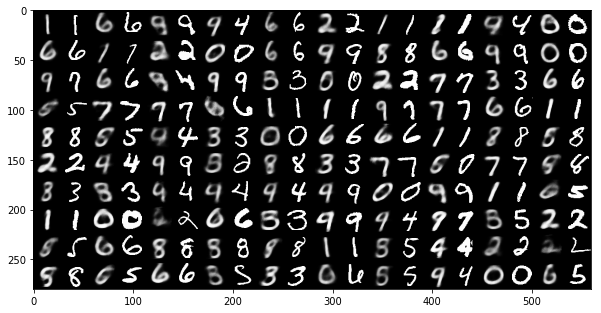

In [6]:
# Test the trained model: reconstruction
batch = mnist.test.next_batch(100)
x_reconstructed = model.reconstructor(batch[0])

n = np.sqrt(model.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')

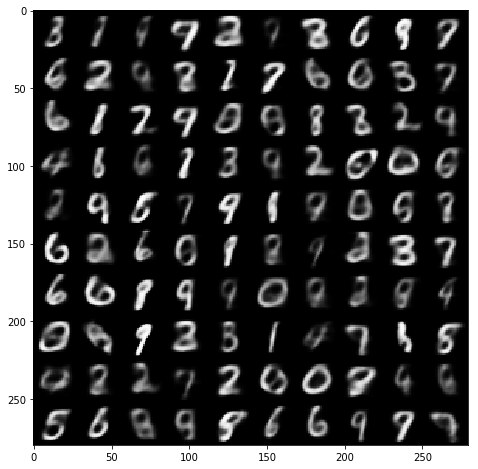

In [7]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [8]:
tf.reset_default_graph()
# Train the model with 2d latent space
model_2d = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=50, n_z=2)

[Epoch 0] Loss: 206.90040588378906, Recon loss: 194.64901733398438, Latent loss: 12.251367568969727
[Epoch 5] Loss: 182.26930236816406, Recon loss: 177.0625, Latent loss: 5.2068095207214355
[Epoch 10] Loss: 181.69418334960938, Recon loss: 177.31243896484375, Latent loss: 4.381726264953613
[Epoch 15] Loss: 175.08050537109375, Recon loss: 170.38650512695312, Latent loss: 4.693993091583252
[Epoch 20] Loss: 177.86004638671875, Recon loss: 173.15260314941406, Latent loss: 4.707465171813965
[Epoch 25] Loss: 162.1524658203125, Recon loss: 156.7085723876953, Latent loss: 5.443881034851074
[Epoch 30] Loss: 165.6923065185547, Recon loss: 161.17715454101562, Latent loss: 4.515141010284424
[Epoch 35] Loss: 172.0480499267578, Recon loss: 167.01976013183594, Latent loss: 5.028286933898926
[Epoch 40] Loss: 167.22296142578125, Recon loss: 162.4279327392578, Latent loss: 4.795026779174805
[Epoch 45] Loss: 166.6378936767578, Recon loss: 161.8175811767578, Latent loss: 4.8203043937683105
Done!


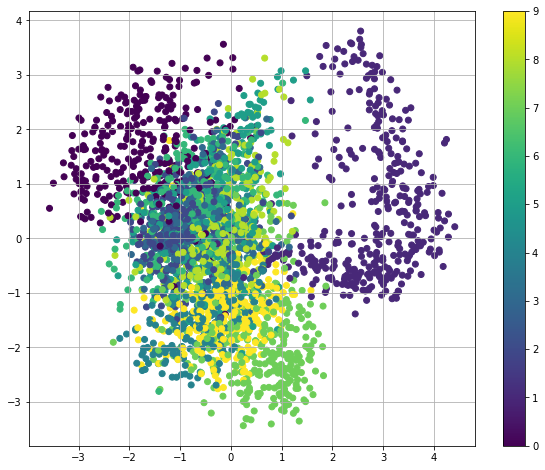

In [9]:
# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.colorbar()
plt.grid()

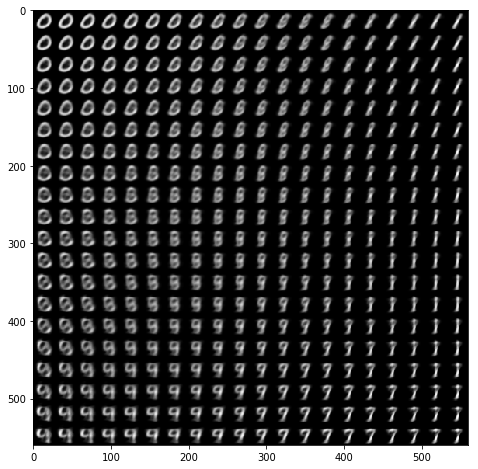

In [10]:
# Test the trained model: transformation
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")